# Introduction

This notebook will investigate how cloud coverage data (from NOAA-CDO) and irradiance data (from NREL SRRL) agree.  If cloud coverage data matches well with irradiance data (in an expected way), this could be use for training machine learning models to detect cloudy and clear sky periods.

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

# Load/merge weather and performance data

Weather cloud coverage data is given by NOAA CDO (as hourly normals, https://www.ncdc.noaa.gov/cdo-web/datasets).  Picked sites nearest Denver, CO area so the SRRL irradiance data could be used with a 'close enough' geographic location.  SRRL data is gathered from https://www.nrel.gov/midc/srrl_bms/.  The CDO data was only available for 2010.

In [2]:
cdo_file = os.path.expanduser('~/data_sets/cdo/Denver_CO_hourly_normals_2010.csv')
srrl_file = os.path.expanduser('~/data_sets/srrl/20100101.csv')

In [3]:
cdo_cols = ['date', 'elevation', 'latitude', 'longitude', 
            'hly-clod-pctbkn', 'hly-clod-pctclr', 'hly-clod-pctfew', 'hly-clod-pctovc', 'hly-clod-pctsct']
cdo_cols = [i.upper() for i in cdo_cols]
srrl_cols = ['DATE (MM/DD/YYYY)', 'MST', 'Global 40-South PSP [W/m^2]', 'Global 40-South LI-200 [W/m^2]']

In [4]:
cdo_data = pd.read_csv(cdo_file, parse_dates=['DATE'], usecols=cdo_cols, index_col=['DATE'])

In [5]:
cdo_data.indexex = cdo_data.index.tz_localize('Etc/GMT+7')

In [6]:
cdo_data.head()

,ELEVATION,LATITUDE,LONGITUDE,HLY-CLOD-PCTBKN,HLY-CLOD-PCTCLR,HLY-CLOD-PCTFEW,HLY-CLOD-PCTOVC,HLY-CLOD-PCTSCT
DATE,,,,,,,,
2010-01-01 00:00:00,1480.7,39.13417,-108.54,119,434,66,342,39
2010-01-01 01:00:00,1480.7,39.13417,-108.54,98,450,70,345,36
2010-01-01 02:00:00,1480.7,39.13417,-108.54,114,422,84,340,39
2010-01-01 03:00:00,1480.7,39.13417,-108.54,116,433,71,342,39
2010-01-01 04:00:00,1480.7,39.13417,-108.54,93,417,68,355,66


In [25]:
srrl_data = pd.read_csv(srrl_file, usecols=srrl_cols)

In [26]:
srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])

In [27]:
srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')

In [28]:
srrl_lat = 39.742
srrl_lon = -105.18
srrl_tilt = 40
srrl_azimuth = 180
srrl_elevation = 1828.8

In [29]:
cdo_data['LATITUDE'].unique()

array([ 39.13417,  38.2901 ,  38.81   ,  39.71667])

In [30]:
cdo_data['LONGITUDE'].unique()

array([-108.54  , -104.4983, -104.6884, -104.75  ])

Only examine CDO station at 39.71667, -104.75.

In [47]:
sample_site = cdo_data[(cdo_data['LATITUDE'] == 39.71667) & (cdo_data['LONGITUDE'] == -104.75)]

In [48]:
#sample_site = sample_site[(sample_site.index.month == 2) & (sample_site.index.day <=7)]

In [49]:
sample_site.keys()

Index(['ELEVATION', 'LATITUDE', 'LONGITUDE', 'HLY-CLOD-PCTBKN',
       'HLY-CLOD-PCTCLR', 'HLY-CLOD-PCTFEW', 'HLY-CLOD-PCTOVC',
       'HLY-CLOD-PCTSCT'],
      dtype='object')

<IPython.core.display.Javascript object>


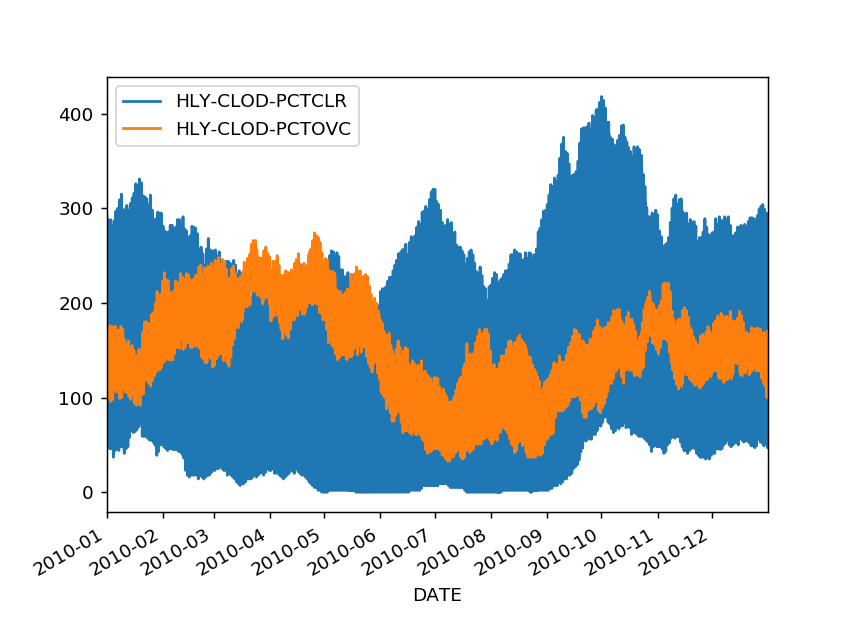

In [50]:
sample_site[['HLY-CLOD-PCTCLR', 'HLY-CLOD-PCTOVC']].plot()

In [51]:
sample_site['HLY-CLOD-PCTCLR'].autocorr(lag=24)

0.99828989674074886

The data appears to not be real-time tracked.  The data is almost perfectly autocorrelated day-to-day...  Not sure what to make of this.  Will revisit in the future.